In [21]:
from scipy.misc import imresize
import matplotlib.pyplot as plt
%matplotlib inline
print 1
from matplotlib.mlab import csv2rec
import os
print 2
import numpy as np
from scipy.ndimage import imread
import itertools
import mahotas as mh


1
2


In [2]:
#Build dataset

In [3]:
data_path = "../data/Beckman_originals/"
_raw_images = os.listdir( data_path)
metadata = csv2rec("/Users/rishirawat/Dropbox/Rishi_CAMM/ImageProcessing/mergedMetaData.csv")

print len(_raw_images)

raw_images = []
print "missing metadata for:"
for img in _raw_images:
    if img not in metadata["filename"]:
        print img, 
    else:
        raw_images.append(img)
        
print ("now calculating labels for the %i raw images" % len(raw_images))

labels = np.zeros(len(raw_images))
for i, img in enumerate(raw_images):
    labels[i] = metadata[ metadata["filename"] == img][ "diagnosis"] == 'DCIS'
    
print; print "all raw-images labeled?" , len(raw_images) == len(labels)

344
missing metadata for:
.DS_Store S13-92 A1-2 A.tif S13-92 A1-2 B.tif S13-92 A1-2 C1.tif S13-92 A1-2 C2.tif S13-92 A1-9 A.tif S13-92 A1-9 B.tif S13-92 A1-9 C.tif S13-94 A1-17 A.tif S13-94 A1-17 B.tif S13-94 A1-3 A.tif S13-94 A1-3 B.tif S13-95 A2-2 A.tif S13-95 A2-2 B1.tif S13-95 A2-2 B2.tif S13-95 A2-2 C.tif S13-95 A2-2 D.tif now calculating labels for the 327 raw images

all raw-images labeled? True


In [4]:
# do a quality check. Print the biggest and smallest image

In [5]:
hmin, wmin = 10000, 10000
for i in range(len(raw_images)):
    img = imread( data_path + raw_images[i] )
    wmin = min(wmin, img.shape[1])
    hmin = min(hmin, img.shape[0])
print wmin, hmin

222 214


In [6]:
# Split the Image
np.array([1,2,3,4,5,6,7,8,9,0])[np.random.permutation(np.arange(5))]

array([5, 2, 1, 4, 3])

In [183]:
class MakeDataset():
    def __init__(self):
        self.outputSize = 30
        self.stepSize = 30
        self.standardized = False
        
    def randomize(self, data, labels):
        rVector = np.random.permutation( len(data) )
        return np.array(data)[rVector], np.array(labels)[rVector]
        
    def processImage(self, image):
        """generic funciton, overwrite this in case you want to pre-process, eg. extract nuclei, otsu filter,etc"""
        return image
    
    def splitImage(self, arr, squareSize, stepSize, label):
        out = []
        hPos, vPos = 0,0
        while (vPos + squareSize < arr.shape[0]):
            while(hPos + squareSize < arr.shape[1]):
                a = arr[vPos:squareSize+vPos, hPos:squareSize+hPos]
                out.append(a)
                hPos += stepSize
            vPos += stepSize
            hPos = 0
        return out, [label]*len(out) 
    
    def cropEdges(self, image, cropsize = 10):
        return image[cropsize:image.shape[0]-cropsize, cropsize:image.shape[1]-cropsize, :]
    
    def doIT(self):
        """Naive implimentation, just divides each thing into small squares. each data item is a small square"""
        ### Not to be confusing, but "new outputs" corresponds to the new small images
        New_outputs, New_labels = [], []

        #calculate data sets
        for i in range(len(raw_images)):
            img = imread( data_path + raw_images[i] ) 
            img = self.cropEdges(img)

            label = labels[i]
            img_b = imresize(img, 25)

            outputs = splitImage(img_b, outputSize, stepSize) #100x100 step size 30 pixels
            print len(outputs)
            
            New_outputs += outputs 
            New_labels += len(outputs) * [label]

            print i,
        return New_outputs, New_labels
    
    def sizeAnalysis(self):
        shapes = np.zeros((len(raw_images),2))
        for i in range(len(raw_images)):
            img = imread( data_path + raw_images[i] ) 
            img = self.cropEdges(img)

            img_b = imresize(img, 25)
            shapes[i,]= img_b.shape[0:2]
        return shapes
    
            
    def StandardizeSamples(self, slidingWindowSize = 100, stepsize = 100):
        """ Samples:
            first go through all slides and pass a non-repeating moving window to subdivide them into 'samples'
            this will give the # of cancer cases vs. non-cancer cases. Note, each 'sample' should be large enough. 
            
            Subsamples:
            from here, we pass overlapping moving windows and take permutations. The point of this is to make the 
            training set larger. If we had enough 'samples' we would skip this step.
            
            This is NOT done here. Done at Runtime. 
            
            """
            
        ### Not to be confusing, but "samples" corresponds to the first round, sub samples = training data
        samples, sample_labels = [], []

        print "beginning to standardize samples"
        
        #calculate data sets
        for i in range(len(raw_images) ):
            print i,
            img = imread( data_path + raw_images[i] ) 
            img = self.cropEdges(img)
            img_sm = self.processImage(img)
            #img_sm = imresize(img, 25, interp='nearest')
            
            L = labels[i]
            s,l = self.splitImage(img_sm, slidingWindowSize, stepsize, L)
            
            samples += s
            sample_labels += l
        
        samples = np.array(samples)
        sample_labels = np.array(sample_labels)

        self.standardized = True
        print """STANDARDIZE SAMPLES OUTPUT:
        
        The original dataset has %i files with diagnoses.
        %f percent are cancer.
        
        After passing a window of equivalent size %i px by %i px, I augmented the dataset so that now there are
        %i diagnoses
        %f percent are cancer.
        """ %( len(raw_images), np.array(labels).mean() * 100, slidingWindowSize, slidingWindowSize,
              len(samples), np.array(sample_labels).mean() * 100)
        
        self.samples, self.sample_labels = self.randomize(samples, sample_labels)
        
        #return self.samples, self.sample_labels 
   
    def get8RotationFlips(self, arr):
        "return the other 3 rotations of an array"
        arr2 = np.fliplr(arr)
        
        return [arr, np.rot90(arr, 1), np.rot90(arr, 2), np.rot90(arr, 3),
            arr2, np.rot90(arr2, 1), np.rot90(arr2, 2), np.rot90(arr2, 3)]
        
        
      
    
    def FlipRotateSamples(self):
        newSamples = []
        newLabels = []
        
        for i, s in enumerate(self.samples):
            newSamples += self.get8RotationFlips(s)
            newLabels += [ self.sample_labels[i]] * 8

        self.samples_rotated , self.sample_labels_rotated = self.randomize(newSamples, newLabels)
        print "Samples have been flipped and rotated (*8), and are now in self.samples_rotated / self.sample_labels_rotated"
    
        
        
    def Shrink_2_3_viaPermute(self):
        """reduces size to two_thirds overall. Note, if array is not a mult of 3, some loss occurs at bot/right edge
        returns 126 images (9 choose 4) 
        
        Note, doing this will reduce the largest possible pattern to a size of originalsize/3
        """
        
        self.permutedImages = []
        self.permutedLabels = []
        
        for i, originalSample in enumerate(self.samples_rotated):
            rL = self.sample_labels_rotated[i]
            self.permutedLabels += [rL] * 126
   
            subsamples = m.splitImage(originalSample, 33, 33, 1)[0] #len = 16
            c = itertools.combinations(subsamples, 4)

            for _ in range(126):
                pieces = c.next()

                i2 = np.vstack((
                    np.hstack((pieces[0], pieces[1])), np.hstack((pieces[2], pieces[3]))
                ))

                self.permutedImages.append(i2)
        self.permutedImages, self.permutedLabels = self.randomize(self.permutedImages, self.permutedLabels)
        
        print """
            permuted samples and cut them down to size of 66 x66 however largest continguous unit is 33x33. N samples, N lables =
        """, len(self.permutedImages), len(self.permutedLabels)
        
    def WriteToFile(self, data, labels, datafilename, labelfilename):
        data.dump(datafilename)
        labelfilename.dump(labelfilename)

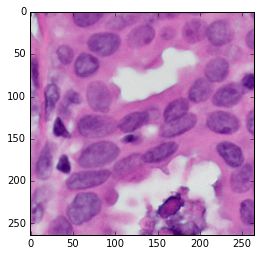

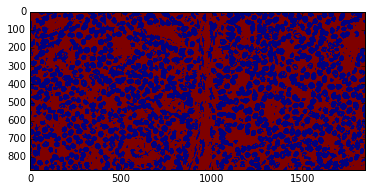

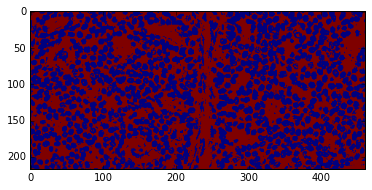

In [197]:
#apply Opening and Closing morphological changes
import skimage
from skimage.morphology import disk
from skimage.filters import threshold_otsu, rank
from skimage.util import img_as_ubyte

import matplotlib
import matplotlib.pyplot as plt

from scipy import ndimage

radius = 1
selem = disk(radius)


plt.imshow(img11[0:66*4,0:66*4])
plt.show()
def ExtractNucleiNaive(rgb = imread("../data/Beckman_originals/14-DCIS B.tiff")):
    img2 = rgb.max(2)
    
    #img2 = mahotas.thresholding.bernsen(img2, 50, mh.otsu(img2))
    
    img2 = img2 > mh.otsu(img2) #global OTSU threshold
    
    img3 = ndimage.binary_opening(img2, selem, iterations=1)
    img4 = ndimage.binary_closing(img3, selem, iterations=1)
    return img4 #img2

plt.imshow(ExtractNucleiNaive(img)); plt.show()
plt.imshow(imresize(ExtractNucleiNaive(img), 25, interp='nearest'))


In [191]:
#D is the result of taking a 66 moving window over the image
d = MakeDataset()
d.processImage = ExtractNucleiNaive
d.StandardizeSamples(224,224)
#d.FlipRotateSamples()




beginning to standardize samples
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 2

In [195]:
#post process
#shrink to 28x28, make binary (mean adjustment can happen later in Theano)

resizedSamples = np.zeros((d.samples.shape[0], 28, 28))

for i, sample in enumerate(d.samples):
    resizedSamples[i] = imresize(sample, (28,28) , interp='nearest') # 100


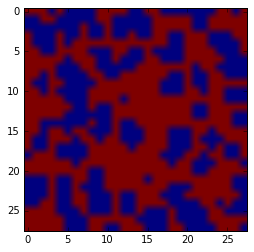

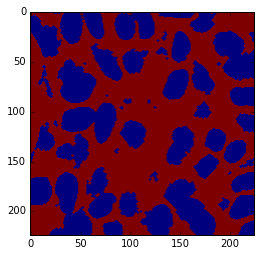

In [196]:
plt.imshow(resizedSamples[1000])
plt.show()
plt.imshow(d.samples[1000])

In [201]:
resizedSamples.dump("data224_to_28x28.pickle")
d.sample_labels.dump( "labels224_to_28x28.pickle")

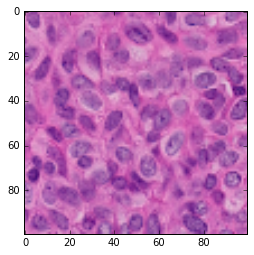

9

In [212]:
#m.StandardizeSamples()
#m.Subsample_and_permute()
originalSample = m.samples[0]
plt.imshow(tr[0:100,])
plt.show()

plt.imshow(tr[0:50,0:50])


# for a given image, originalSample

subsamples = m.splitImage(originalSample, 32, 33, 1)[0] #len = 16
subsamples = np.random.permutation(subsamples)
len(subsamples)
#plt.imshow(subsamples[1])

import itertools
c = itertools.combinations(subsamples, 4)

for _ in range(126):
    pieces = c.next()

    i2 = np.vstack((
        np.hstack((pieces[0], pieces[1])), np.hstack((pieces[2], pieces[3]))
    ))
    
plt.show()
plt.imshow(i2)

len(subsamples)

In [214]:
originalSample.shape

(100, 100, 3)

In [188]:
np.stack(pieces[0],pieces[1]).shape
#len(m.samples) * 8 * 126
# while True:
#     x = c.next()
#     if x == False: print 2
#     print 1,
# len(x)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

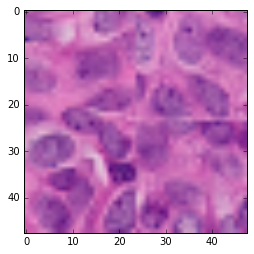

In [202]:

plt.imshow(i2)

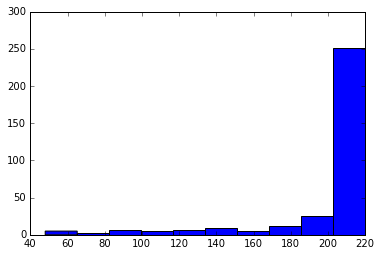

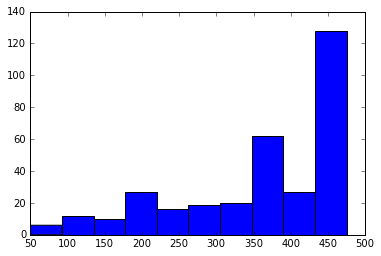

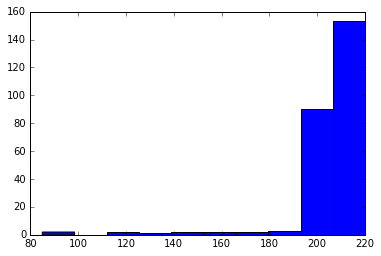

257


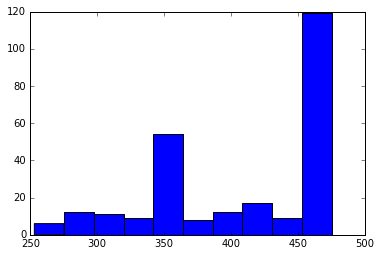

In [91]:
plt.hist(sizes[:,0])
plt.show()
plt.hist(sizes[:,1])
plt.show()

## thinking of taking all slides > 450 wide
sizes2 = sizes[sizes[:,1]>250]
plt.hist(sizes2[:,0])
plt.show()
plt.hist(sizes2[:,1])
print(len(sizes2))

dataset size: (30, 30, 3) x 23540   nlabels= 23540


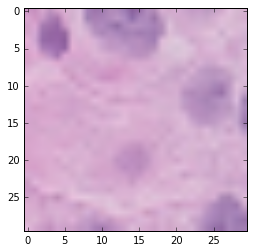

In [71]:
print "dataset size:", d[0].shape,"x", len(d), "  nlabels=", len(l)
plt.imshow(d[10000])

In [54]:
print cropEdges(img)



New_outputs = np.array(New_outputs)
New_labels = np.array(New_labels)


None


In [50]:
img